In [1]:
import numpy as np
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
example.keys()

dict_keys(['samples', 'samplingrate', 'frames', 'preemph', 'windowed', 'spec', 'mspec', 'mfcc', 'lmfcc'])

In [69]:
example["samplingrate"]

20000

In [77]:
example["frames"].shape

(91, 400)

In [3]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
data.shape

(44,)

In [41]:
len(data)

44

In [ ]:
data_item = data[0]
data_item.keys()

dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples'])

In [75]:
data_item["samples"][5]


-2

In [5]:

example["samples"].shape


(18432,)

In [6]:
import matplotlib.pyplot as plt

def plot_comparison(example_, function_, title1="from example", title2="from function", figsize=(12, 8)):
    
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)
    plt.pcolormesh(example_, shading="auto")
    plt.title(title1)
    plt.subplot(2, 1, 2)
    plt.pcolormesh(function_, shading="auto")
    plt.title(title2)
    plt.tight_layout()
    plt.show()


# 4.1 Verify Enframe function

(91, 400)


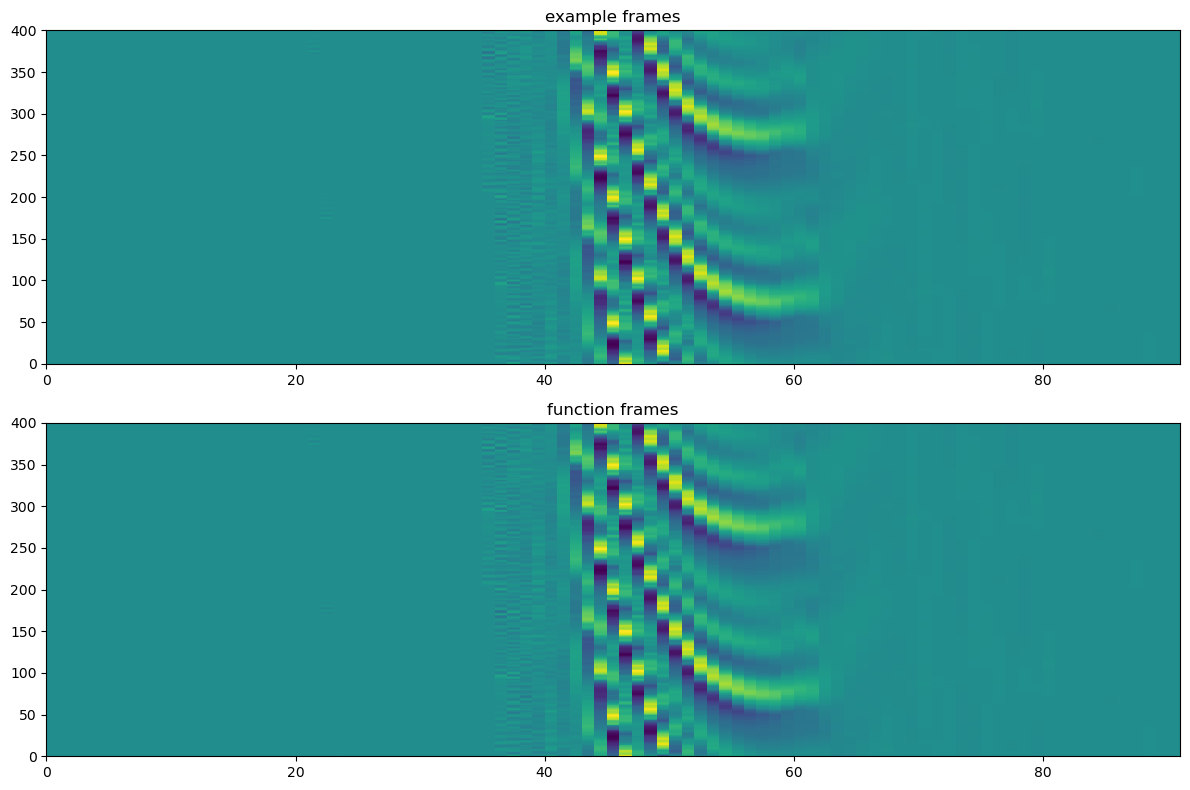

In [7]:

print(example["frames"].shape)


def enframe(samples, winlen, winshift, samplingrate=20000):
    winlen_samples = int(winlen * samplingrate)
    winshift_samples = int(winshift*samplingrate)
    n_f = int((len(samples) - winlen_samples) / winshift_samples) + 1
    frames = np.zeros((n_f, winlen_samples))
    for i in range(n_f):
        start = i * winshift_samples
        end = start + winlen_samples
        frames[i, :] = samples[start:end]
    return frames

# Test  be careful of the time --------------------------------------------------------------------------------------------------
winlen = 0.02
winshift = 0.01
outcome = enframe(example["samples"],winlen, winshift)
plot_comparison(example["frames"].T, outcome.T, "example frames", "function frames")

# 4.2 Pre-emphasis

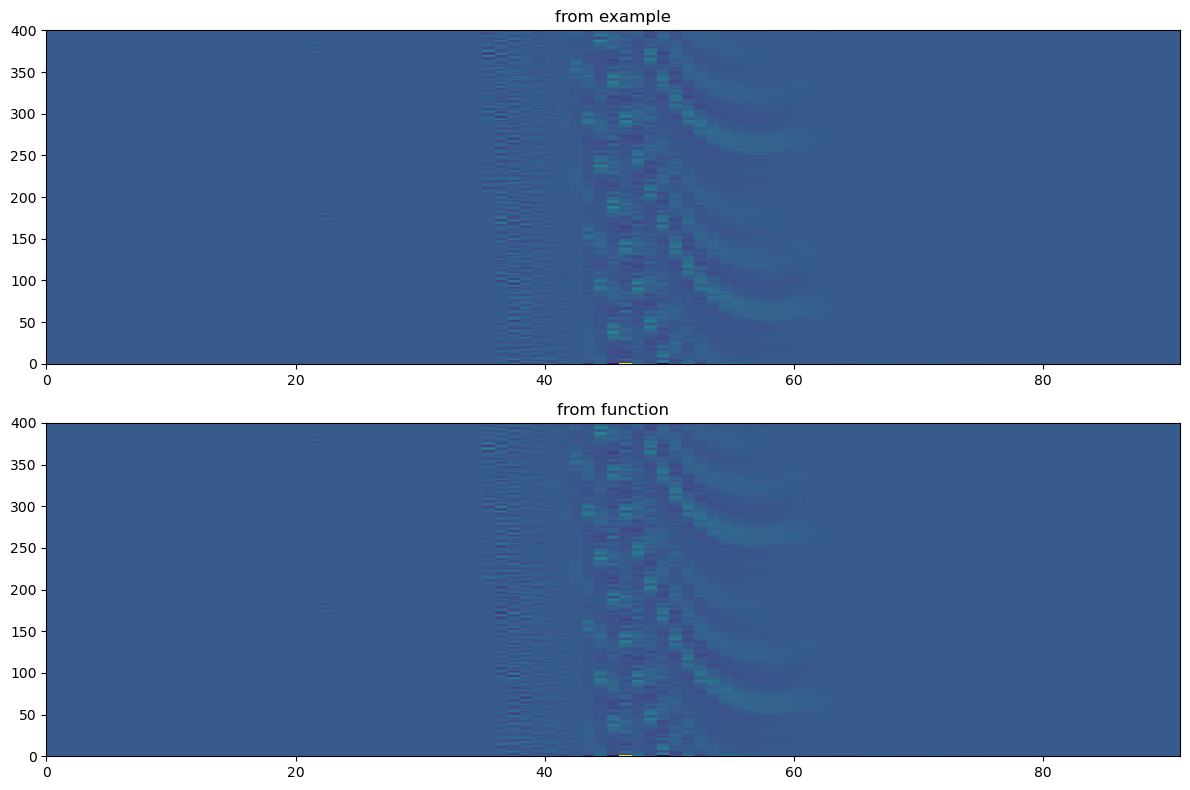

In [8]:
from scipy.signal import lfilter
def preemp(input, p=0.97):
    b = [1, -p]
    a = [1] 
    output = np.zeros_like(input)
    for i in range(input.shape[0]):
        output[i] = lfilter(b, a, input[i])
    return output

outcome_peep = preemp(outcome)

# Test  
plot_comparison(example["preemph"].T,outcome_peep.T)

# 4.3 Hamming Window

C:\Users\25954\AppData\Local\Temp\ipykernel_44716\1762894592.py:4: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  wind = hamming(M, sym=False)


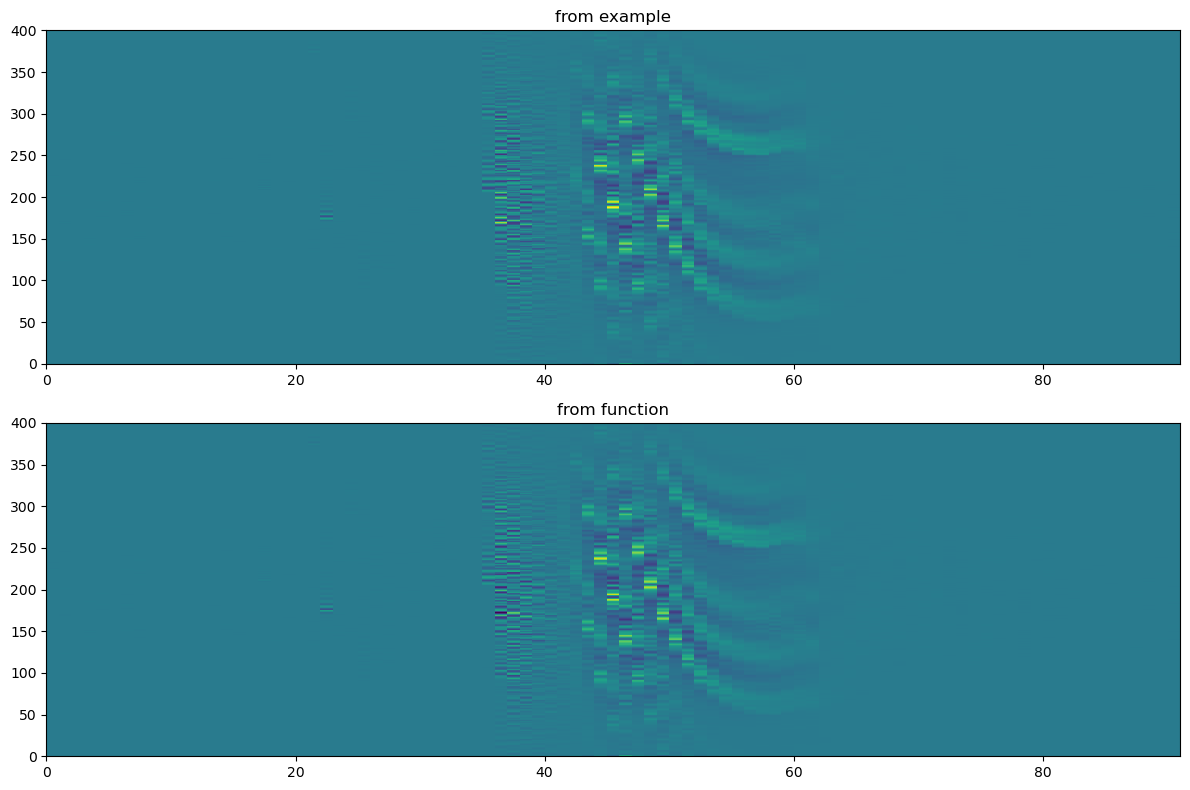

In [9]:
from scipy.signal import hamming
def windowing(input):
    _, M = input.shape
    wind = hamming(M, sym=False)
    return input * wind

outcome_window = windowing(outcome_peep)

# Test
plot_comparison(example["windowed"].T,outcome_window.T)

C:\Users\25954\AppData\Local\Temp\ipykernel_44716\3945011370.py:2: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  wind = hamming(M, sym=False)


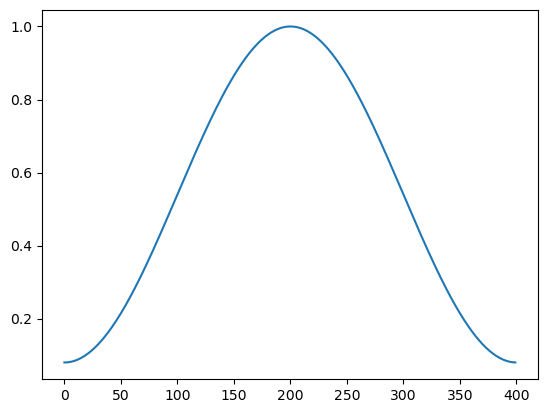

In [78]:
M = 400  
wind = hamming(M, sym=False)

plt.plot(wind)


# 4.4 Fast Fourier Transform

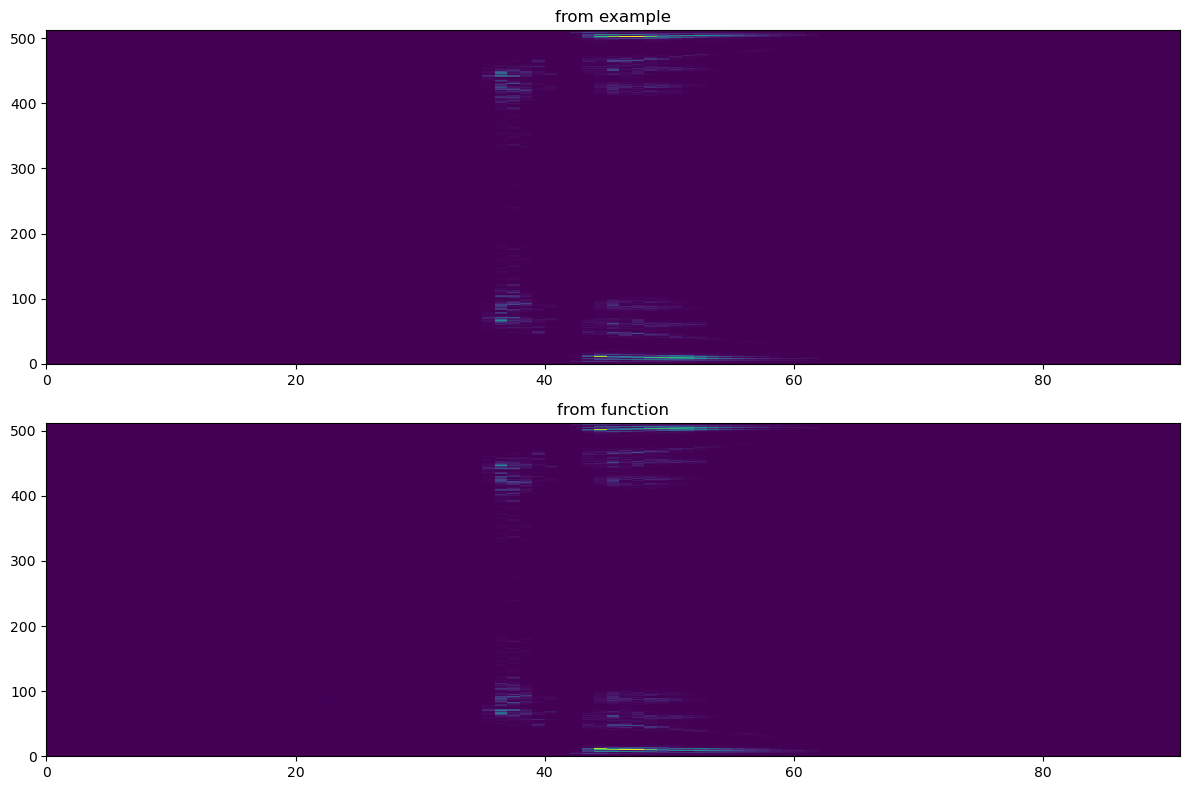

(91, 512)


10000.0

In [81]:
from scipy.fftpack import fft
def powerSpectrum(input, nfft):
    fft_input = fft(input,nfft)
    power_spec = np.abs(fft_input)**2
    return power_spec

# Test
nfft = 512
outcome_ps = powerSpectrum(outcome_window, nfft)
plot_comparison(example["spec"].T,outcome_ps.T)
print(outcome_ps.shape)
example["samplingrate"]/2

# 4.5 Mel filterbank log spectrum

(91, 40)


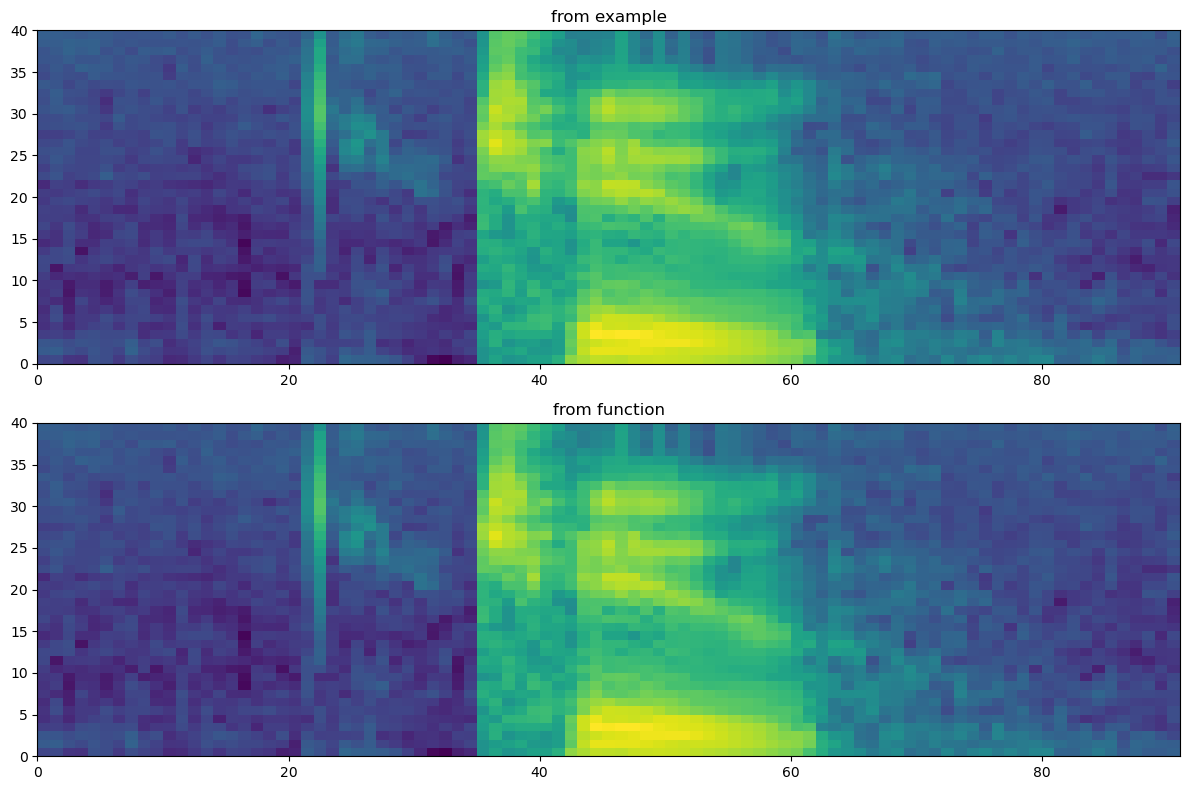

In [82]:
example["mspec"].shape
from lab1_tools import trfbank
def logMelSpectrum(input, samplingrate):
    n_frames, nfft = input.shape
    fbank = trfbank(samplingrate, nfft)
    mel_spec = np.dot(input, fbank.T)
    log_mel = np.log(mel_spec)
    return log_mel, fbank

outcome_logmel,fbank = logMelSpectrum(outcome_ps,example["samplingrate"])
print(outcome_logmel.shape)
# TEst
plot_comparison(example["mspec"].T,outcome_logmel.T)

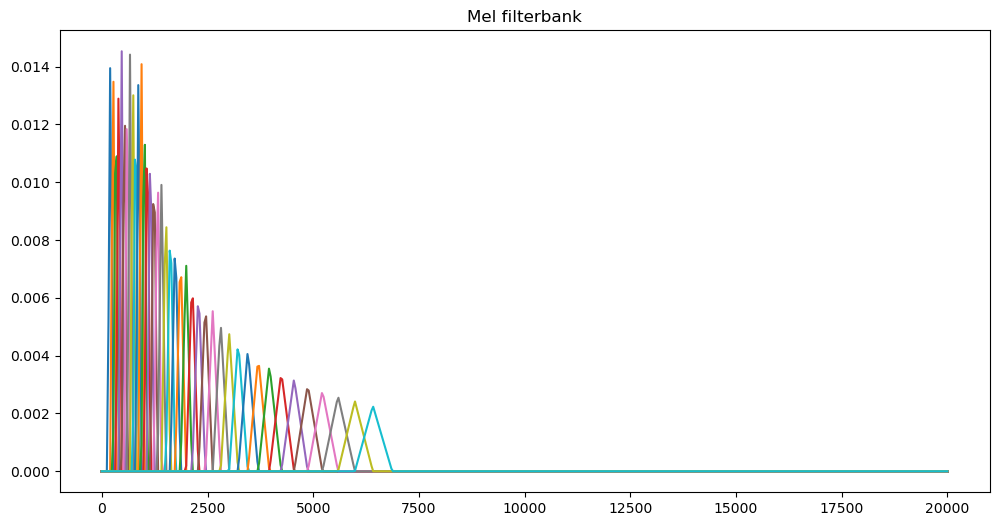

In [19]:
freq_axis = np.linspace(0, example["samplingrate"], fbank.shape[1])
plt.figure(figsize=(12, 6))
for i in range(fbank.shape[0]):
    plt.plot(freq_axis, fbank[i])
plt.title("Mel filterbank")
plt.show()

# 4.6 Cosine Transofrm and Liftering

C:\Users\25954\AppData\Local\Temp\ipykernel_44716\2026630228.py:1: DeprecationWarning: Please use `dct` from the `scipy.fftpack` namespace, the `scipy.fftpack.realtransforms` namespace is deprecated.
  from scipy.fftpack.realtransforms import dct


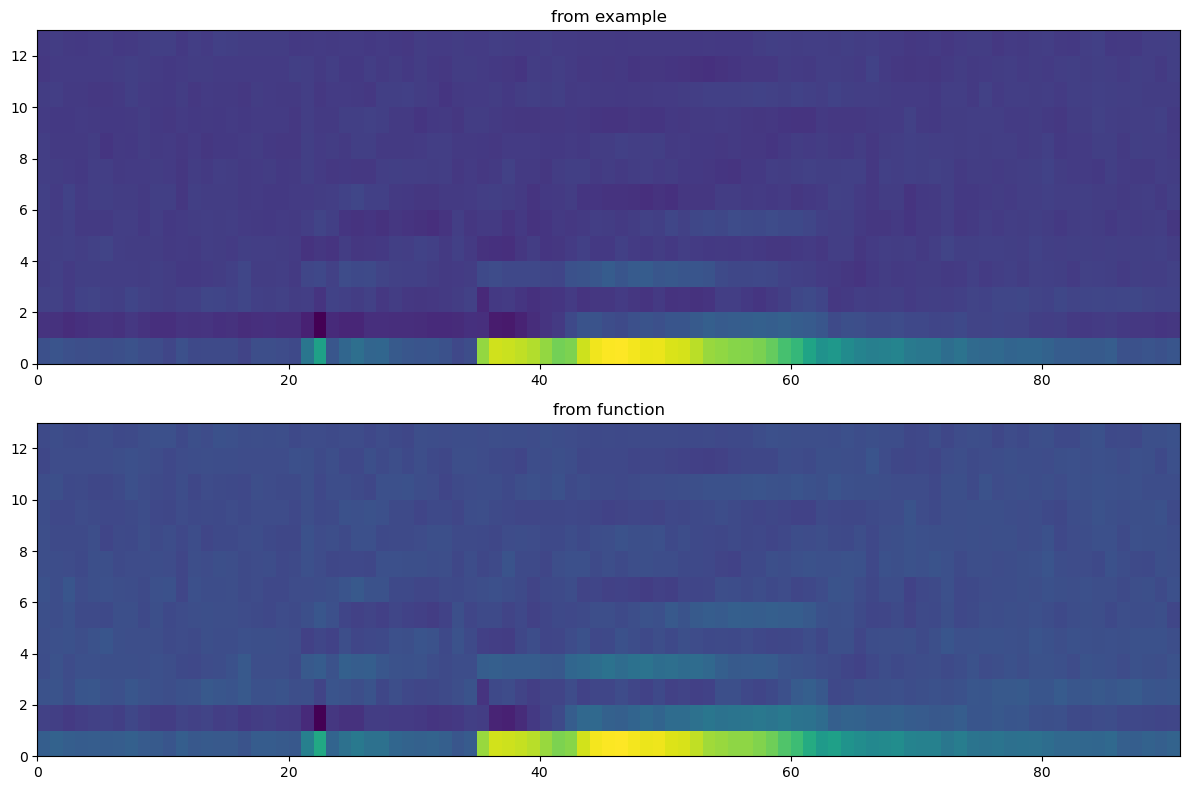

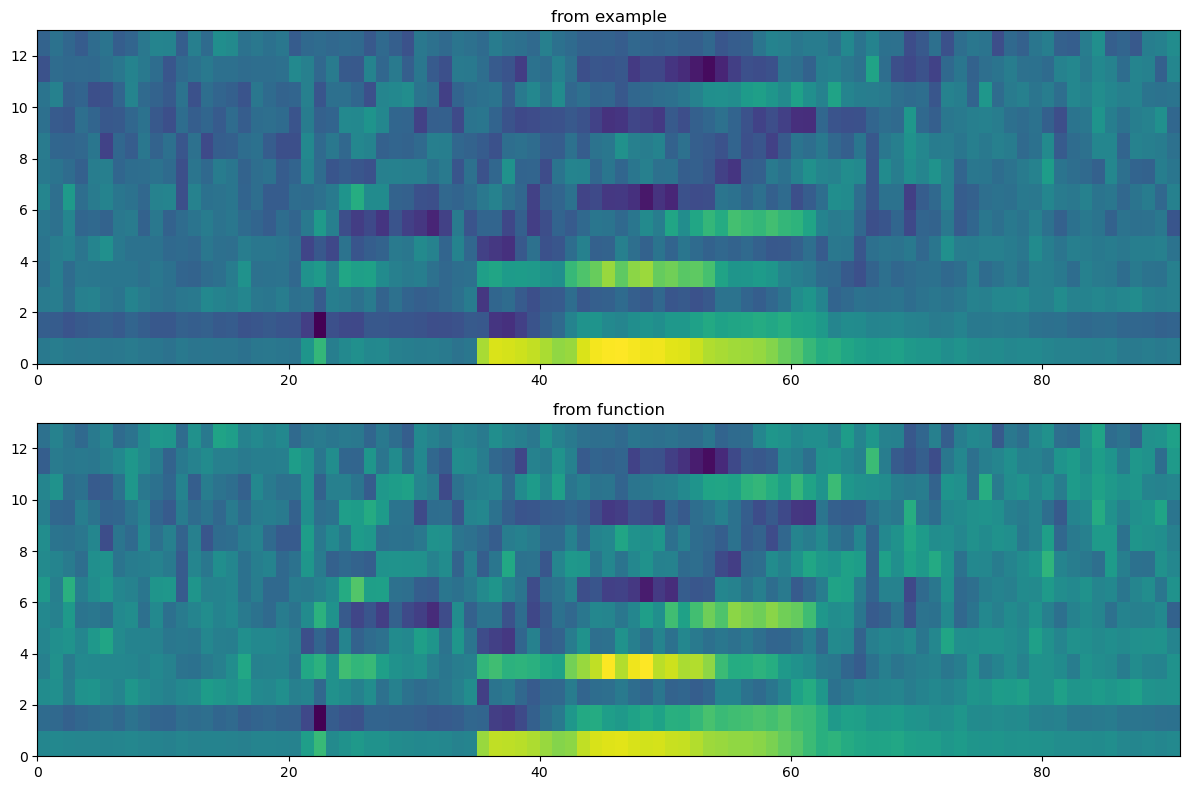

In [20]:
from scipy.fftpack.realtransforms import dct
from lab1_tools import lifter
def cepstrum(input, nceps):
    cepst = dct(input, type=2, axis=1, norm='ortho')[:, :nceps]
    return cepst

outcome_cepst = cepstrum(outcome_logmel, 13)
outcome_cepst_ = lifter(outcome_cepst)
plot_comparison(example["mfcc"].T, outcome_cepst.T)
plot_comparison(example["lmfcc"].T, outcome_cepst_.T)


In [37]:
def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

16640


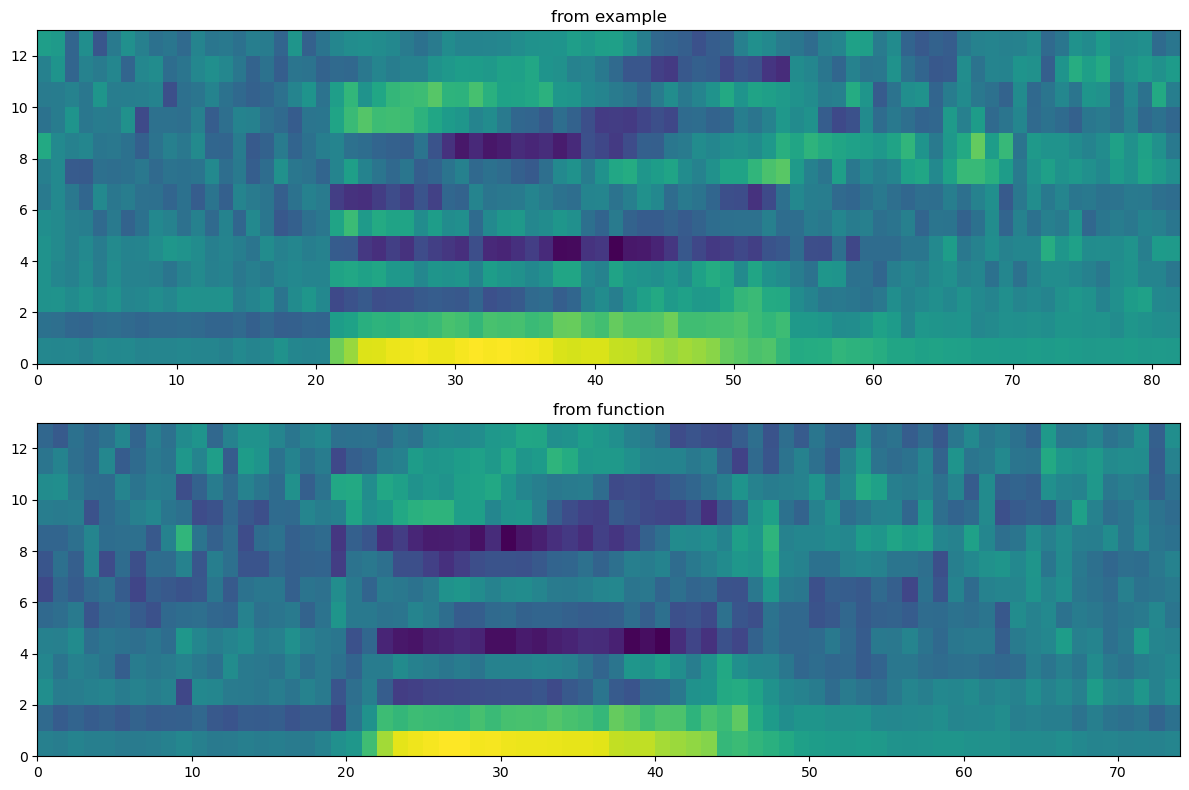

In [ ]:

data_lmfcc1 = mfcc(data_item["samples"],winlen,winshift)
print(len(data_item["samples"]))
data_lmfcc2 = mfcc(data[1]["samples"],winlen,winshift)
plot_comparison(data_lmfcc1.T,data_lmfcc2.T)

# 5 Feature Correlation

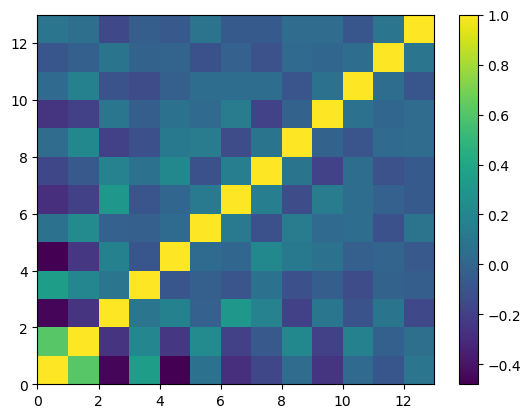

In [85]:
mfcc_data_list = []
for i in range(len(data)):
    mfcc_data_list.append(mfcc(data[i]["samples"],winlen,winshift))

mfcc_array= np.concatenate(mfcc_data_list, axis=0)

plt.pcolormesh(np.corrcoef(mfcc_array.T))
plt.colorbar()


C:\Users\25954\AppData\Local\Temp\ipykernel_44716\1762894592.py:4: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  wind = hamming(M, sym=False)


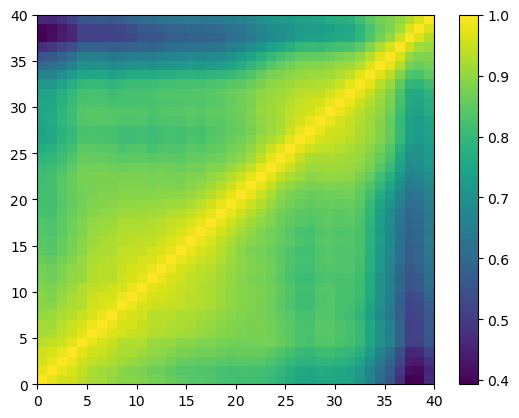

In [86]:
mspec_data_list = []

for i in range(len(data)):
    result = mspec(data[i]["samples"], winlen, winshift)[0]
    mspec_data_list.append(result)

mspec_array = np.concatenate(mspec_data_list,axis =0)
corr_matrix = np.corrcoef(mspec_array.T)
plt.pcolormesh(corr_matrix)
plt.colorbar()



# 6 Explore Speech Segments with Clustering

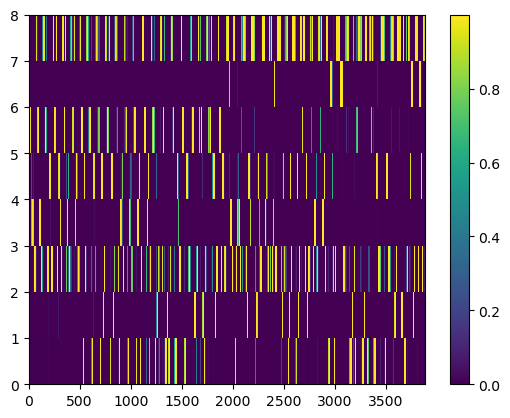

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=16, covariance_type='diag', max_iter=100, n_init=3)
gmm.fit(mfcc_array)
posteriors = gmm.predict_proba(mfcc_array)
plt.pcolormesh(posteriors.T)
plt.colorbar()


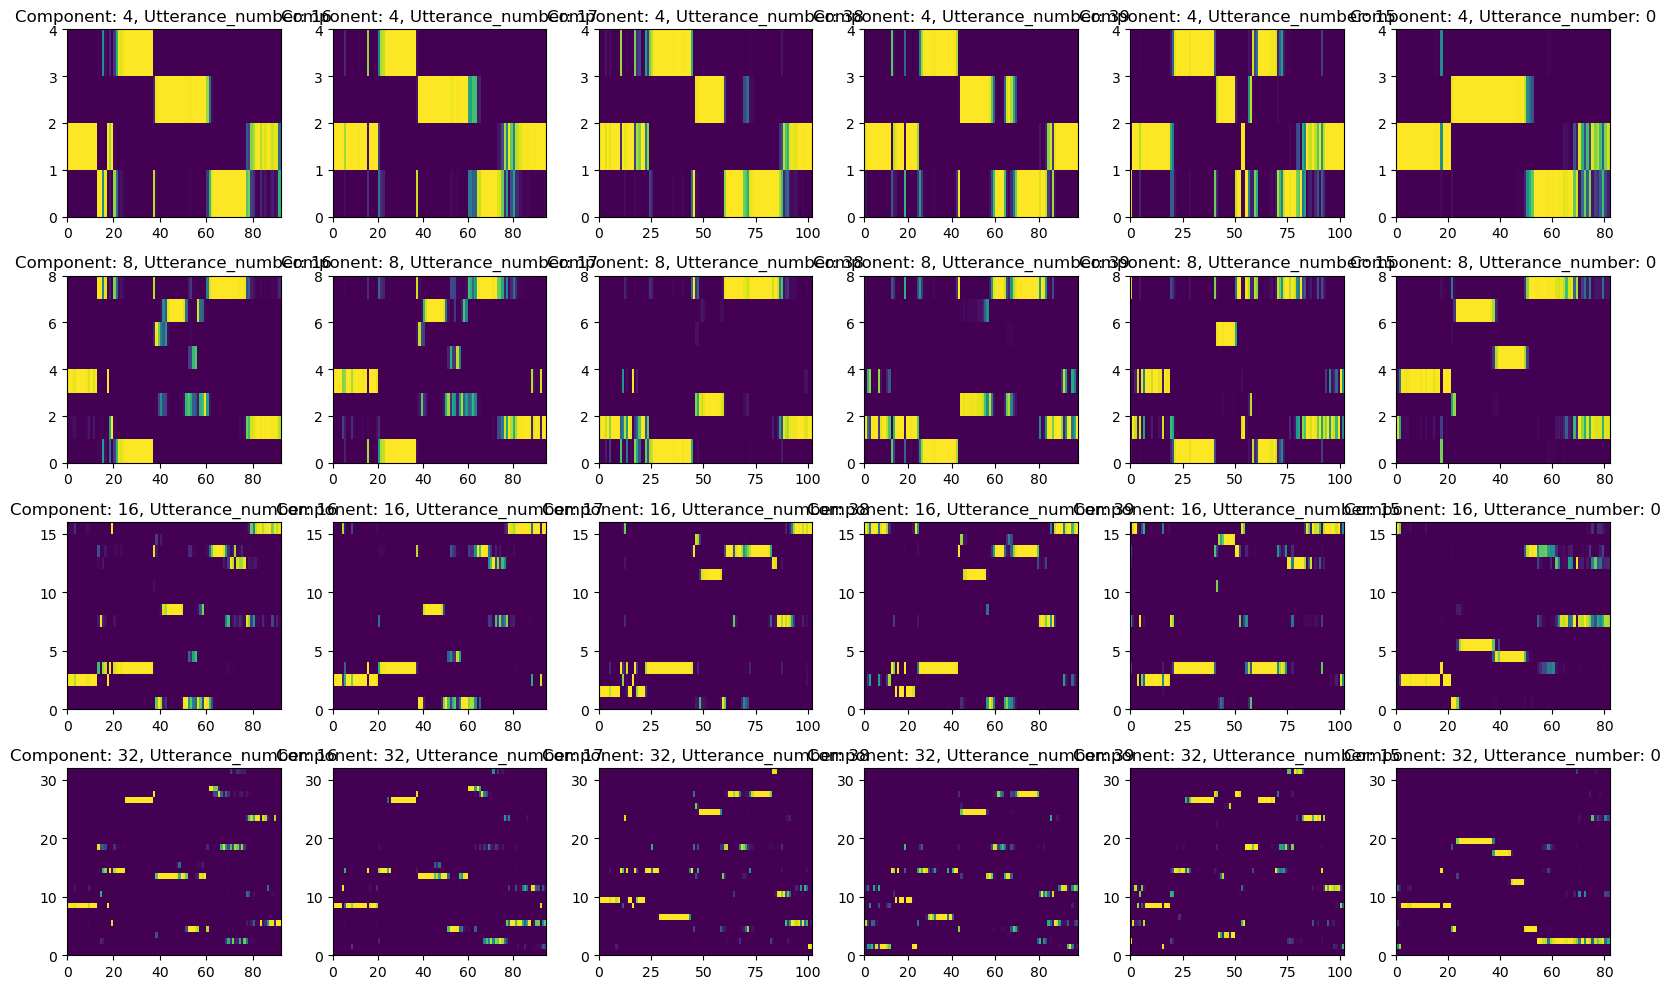

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(16, 10))
components_list = [4, 8, 16, 32]
utterance_ids = [16, 17, 38, 39, 15,0]

for row, n_components in enumerate(components_list):
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=100, n_init=3, random_state=42)
    gmm.fit(mfcc_array)
    
    for col, i in enumerate(utterance_ids):
        mfcc_seven = mfcc(data[i]['samples'], winlen, winshift)
        post = gmm.predict_proba(mfcc_seven)
        axs[row, col].pcolormesh(post.T)
        axs[row, col].set_title(f'Com: {n_components}, Utter: {i}')

plt.tight_layout()
plt.show()


In [106]:
data[0]["digit"]

'o'

# 7 Comparing Utterances

In [108]:
def compute_dist(x, y, winlen, winshift):
    x_mfcc = mfcc(x, winlen, winshift)
    y_mfcc = mfcc(y, winlen, winshift)
    N = x_mfcc.shape[0]
    M = y_mfcc.shape[0] 
    distance = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            distance[i, j] = np.linalg.norm(x_mfcc[i] - y_mfcc[j])
    return distance

# attention here dist is not function
def dtw(dist):
    N,M = dist.shape
    LD = dist
    AD = np.zeros((N, M))
    AD[0, 0] = LD[0, 0]

    # boundary
    for i in range(1, N):
        AD[i, 0] = LD[i, 0] + AD[i-1, 0]
    for j in range(1, M):
        AD[0, j] = LD[0, j] + AD[0, j-1]

    for i in range(1, N):
        for j in range(1, M):
            AD[i, j] = LD[i, j] + min(AD[i-1, j], AD[i, j-1], AD[i-1, j-1])
    
    #path findingggggg
    path = [(N-1, M-1)]
    i, j = N-1, M-1
    while i > 0 and j > 0:
        direction = np.argmin([AD[i-1, j-1], AD[i-1, j], AD[i, j-1]])
        if direction == 0:
            i -= 1
            j -= 1
        elif direction == 1:
            i -= 1
        else:
            j -= 1
        path.append((i, j))

    while(i>0 or j>0):
        if i > 0:
            i -= 1
            path.append((i, j))
        else:
            j -= 1
            path.append((i, j))

    
    d = AD[N-1, M-1] / (N + M) # may delete
    
    return d, AD, path

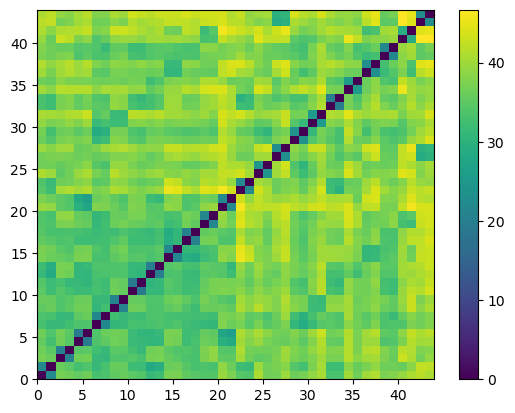

In [111]:

n = len(data)
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        x = data[i]["samples"]
        y = data[j]["samples"]
        dist_matrix = compute_dist(x, y, winlen, winshift)
        d, AD, path= dtw(dist_matrix)
        D[i, j] = d
        

plt.pcolormesh(D)
plt.colorbar()



# hierarchical clustering 

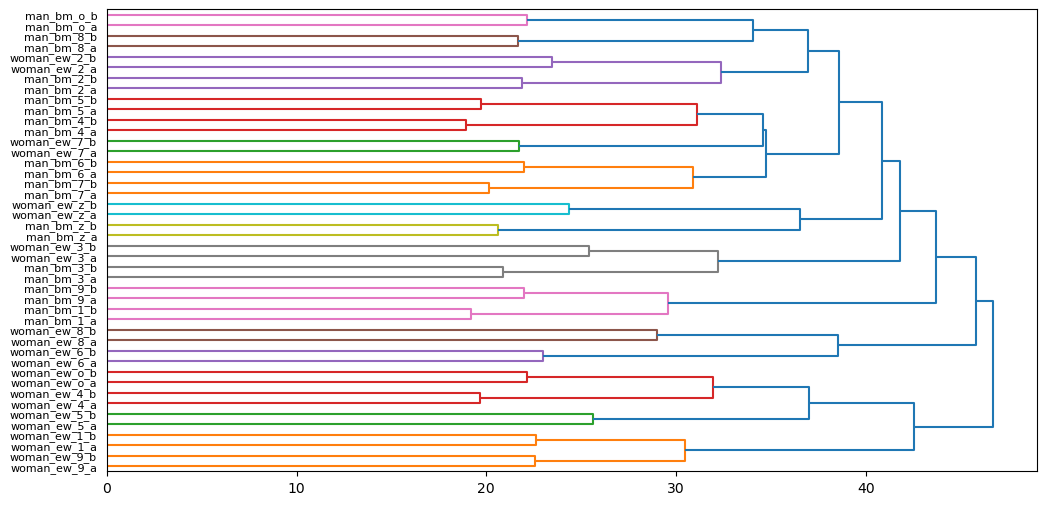

In [116]:

from scipy.cluster.hierarchy import linkage, dendrogram

def tidigit2labels(tidigitsarray):
    labels = []
    nex = len(tidigitsarray)
    for ex in range(nex):
        labels.append(tidigitsarray[ex]['gender'] + '_' + 
                      tidigitsarray[ex]['speaker'] + '_' + 
                      tidigitsarray[ex]['digit'] + '_' + 
                      tidigitsarray[ex]['repetition'])
    return labels

from scipy.spatial.distance import squareform
D_ = squareform(D)
Linka = linkage(D_, method='complete')

labels = tidigit2labels(data)

plt.figure(figsize=(12, 6))
dendrogram(Linka, labels=labels,orientation = 'right')
plt.show()
